### TokaMaker Example: Equilibrium reconstruction in DIII-D Using Real Data {#doc_tMaker_DIIID_ex3}
==========
In this example we show how to perform an equilibrium reconstruction in DIII-D using real data from a gEQDSK file, a k-file and a MHDIn.dat file.

**Warning:** The reconstruction functionality in TokaMaker is still a work in progress, as the PSI-Tri capabilities are activated and tested. Please use with care.

In [1]:
import os
import sys
import json
import random
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain
from OpenFUSIONToolkit.TokaMaker.reconstruction import reconstruction
from OpenFUSIONToolkit.TokaMaker.util import read_eqdsk, read_mhdin, read_kfile

## Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   sol-currents
Revision id:          5f94c52
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/qz/wcp9q1mj0c5fsyjtbt99bvhh0000gn/T/oft_97911/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



## Load Info from gEQDSK File and MHDIn.Dat


In [4]:
shot_tag = '199377.03300'

eqdsk = read_eqdsk('DIIID_files/g'+shot_tag)

e_coil_names = ['ECOILA','ECOILB','E567UP','E567DN','E89DN','E89UP']
f_coil_names = ['F1A', 'F2A', 'F3A', 'F4A', 'F5A', 'F6A', 'F7A', 'F8A', 'F9A', 'F1B', 'F2B', 'F3B', 'F4B', 'F5B', 'F6B', 'F7B', 'F8B', 'F9B']

machine_dict, _ = read_mhdin('DIIID_files/mhdin.dat', e_coil_names, f_coil_names)

## Build Mesh in TokaMaker
Now we build and setup a mesh using DIII-D geometry from a given JSON file and MHDIn.dat. Then, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0. These values come from the gEQDSK file.

In [5]:
plasma_dx = 0.04
coil_dx = 0.03
vv_dx = 0.04
vac_dx = 0.10

with open('DIIID_files/DIIID_geom.json','r') as fid:
    DIIID_geom = json.load(fid)

# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')                     # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')                 # Define the plasma region and resolution
gs_mesh.define_region('vacuum',vv_dx,'vacuum',allow_xpoints=True)  # Define the vacuum inside the VV
# Define regions for VV
for i, vv_segment in enumerate(DIIID_geom["vv"]):
    gs_mesh.define_region('vv{0}'.format(i),vv_dx,'conductor',eta=vv_segment[1])

# Define geometry
gs_mesh.add_polygon(DIIID_geom['limiter'],'plasma',parent_name='vacuum')  # Define the shape of the limiter
gs_mesh.add_enclosed([1.75,1.25],'vacuum')
# Define regions for VV
for i, vv_segment in enumerate(DIIID_geom["vv"]):
    gs_mesh.add_polygon(vv_segment[0],'vv{0}'.format(i),parent_name='air')

### Load E and F Coils from MHDIn.Dat

In [6]:
# Define F coils
for key, coil in DIIID_geom["coils"].items():
    if key.startswith('ECOIL'):
        continue
    gs_mesh.define_region(key,coil_dx,'coil',nTurns=machine_dict['FCOIL'][key][4])
    gs_mesh.add_polygon(coil["pts"],key,parent_name='air')

# Define E Coils
for coil_set_name, coil_set in machine_dict['ECOIL'].items():
    i = 0
    for coil in coil_set:
        coil_name = "{}_{}".format(coil_set_name, i)
        i = i + 1
        r, z, w, h = coil
        gs_mesh.define_region(coil_name,coil_dx,'coil',coil_set=coil_set_name,nTurns=1) # Check nTurns
        gs_mesh.add_rectangle(r, z, w, h, coil_name, parent_name='air')


### Plot Topology

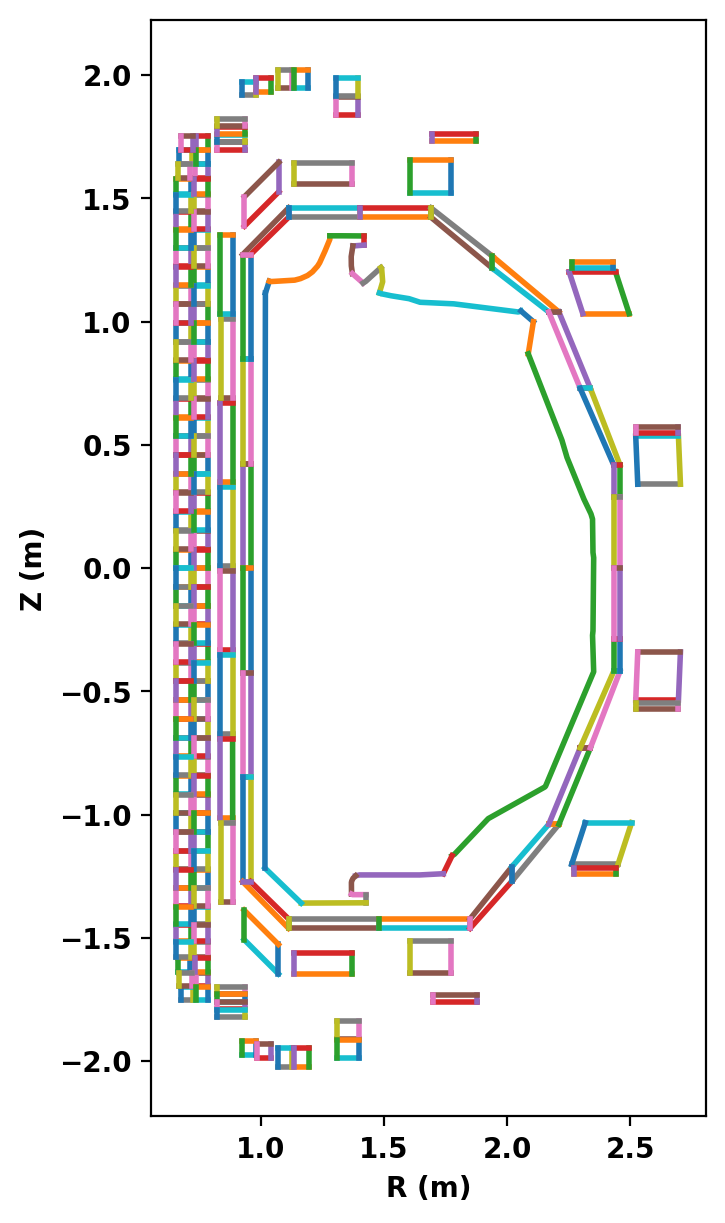

In [7]:
fig, ax = plt.subplots(1,1,figsize=(4,6),constrained_layout=True)
gs_mesh.plot_topology(fig,ax)

plt.show()

### Setup Mesh

In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 = eqdsk['rcentr']*eqdsk['bcentr'])

Assembling regions:
  # of unique points    = 1836
  # of unique segments  = 657
Generating mesh:
  # of points  = 12951
  # of cells   = 25740
  # of regions = 167

**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.574E+01
    # of points  =   12951
    # of edges   =   38690
    # of cells   =   25740
    # of boundary points =     160
    # of boundary edges  =     160
    # of boundary cells  =     160
  Resolution statistics:
    hmin =  8.702E-04
    hrms =  4.001E-02
    hmax =  1.520E-01
  Surface grounded at vertex    1813


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.1689999999999999E-003


At line 5532 of file /Users/johnl/Desktop/OpenFUSIONToolkit-SOL-Currents/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created for argument 'b' of procedure 'mat_add_values'
At line 5536 of file /Users/johnl/Desktop/OpenFUSIONToolkit-SOL-Currents/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created for argument 'b' of procedure 'mat_add_values'


## Update GS Settings

In [9]:
# mygs.settings.sol_currents = True
mygs.update_settings()

## Define vertical stability coils

In [10]:
vsc_signs = {key: 0 for key in mygs.coil_sets}
vsc_signs['F9A'] = 1.0
vsc_signs['F9B'] = -1.0
mygs.set_coil_vsc(vsc_signs)

## Perform Reconstruction

### Create Reconstruction Object

In [11]:
myrecon = reconstruction(mygs)

### Define Helper Functions to Read Sensor Locations
For this example we load data representing flux loops and Mirnov sensor locations and orientations in DIII-D from several text files. The signals in these sensors will be used to constrain the reconstruction along with coil currents and global plasma quantities (eg. $I_p$). First we define two helper functions to read Flux Loop and Mirnov sensor configurations.

In [12]:
def read_points_flux(file_path,  sensor_names = None):
    points = OrderedDict()
    with open(file_path, 'r') as file:
        for line in file:
            if sensor_names is not None:
                name, r, z = line.strip().split()  # Split and ignore the first field (name)
                if name in sensor_names:
                    points[name] = [float(r),float(z)]
            else:
                name, r, z = line.strip().split()  # Split and ignore the first field (name)
                points[name] = [float(r),float(z)]
    return points

def read_points_mag(file_path, sensor_names = None):
    points = OrderedDict()
    with open(file_path, 'r') as file:
        for line in file:
            if sensor_names is not None: 
                name, r, z, pol, orient, _, _, _ = line.strip().split()  # Split and ignore the first field (name)
                if name in sensor_names:
                    points[name] = [float(r), float(z), float(orient)]
            else: 
                name, r, z, pol, orient, _, _, _ = line.strip().split()  # Split and ignore the first field (name)
                points[name] = [float(r), float(z), float(orient)]  # Convert r and z to floats and append
    return points

### Load Sensor Locations From Files

In [13]:
magSensors322 = read_points_mag('DIIID_files/3222magsensorloc.txt')
fluxLoops_onf = read_points_flux('DIIID_files/fcoil_fluxloops.txt')
fluxLoops_vv = read_points_flux('DIIID_files/vv_fluxloops.txt')

### Plot probe locations

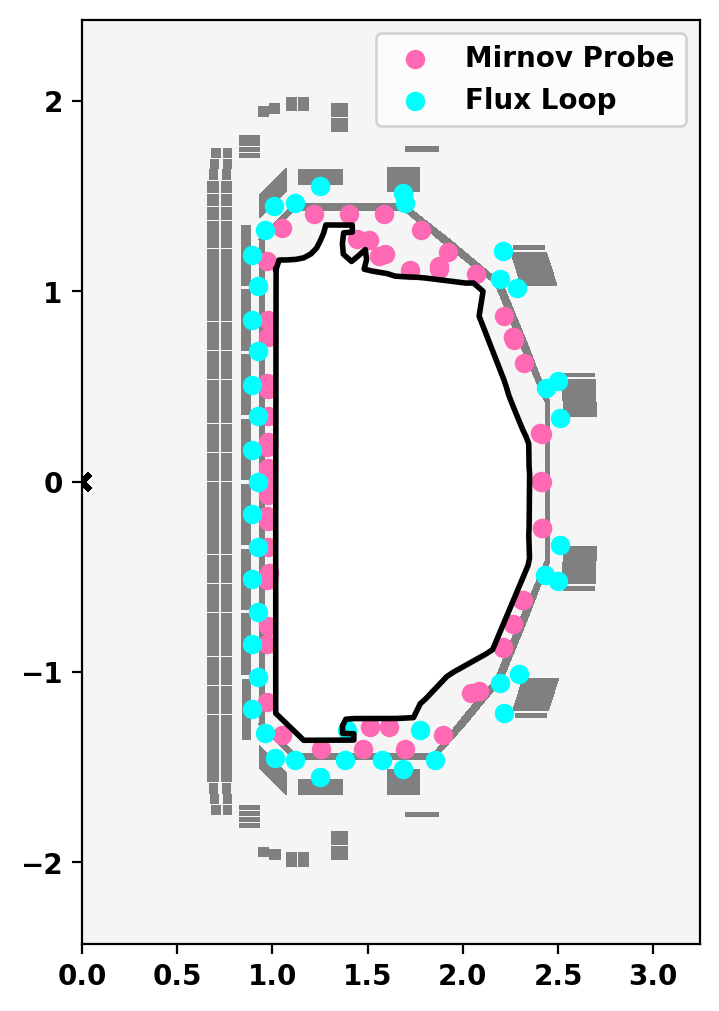

In [14]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color='k')
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)

def plot_sensors(sensors, label, color):
    r_coords = [s[0] for _,s in sensors.items()]
    z_coords = [s[1] for _,s in sensors.items()]
    ax.scatter(x=r_coords, y=z_coords, label=label, color=color)

plot_sensors(magSensors322, label="Mirnov Probe", color='hotpink')
plot_sensors({**fluxLoops_vv, **fluxLoops_onf}, label="Flux Loop", color='cyan')

ax.legend()
plt.show()

### Load Shot Data from DIII-D
Here we load data from a DIII-D k file representing a shot at a given point in time.

In [15]:
probes_dict, loops_dict, e_coil_dict, f_coil_dict, _ = read_kfile('DIIID_files/k'+shot_tag, machine_dict, e_coil_names, f_coil_names)

### Read Data From DIII-D to Mirnov Probes

In [16]:
def convert_Mirnov_coordinates(sensor, angle):
    R, z, _ = sensor
    position = np.array([R, z])

    angle_rads = angle * np.pi / 180
    orientation = np.array([np.cos(angle_rads), 0, np.sin(angle_rads)])
    return position, orientation

B_vals = [probes_dict[key][0] for key in magSensors322 if key in probes_dict]
B_mean = np.mean(np.positive(B_vals))
mirnov_names = []

for key, mag in magSensors322.items():
    if probes_dict[key][1] == 0:
        print("{} not selected.".format(key))
        continue
    position, orientation = convert_Mirnov_coordinates(mag, machine_dict['AMP2'][key])
    mirnov_names.append(key)
    B_meas, _ = probes_dict[key]
    myrecon.add_Mirnov(position, orientation, B_meas, err=0.1*max(B_mean, abs(B_meas)))


MPI7NB322 not selected.


### Read Data From Equilibrium to Flux Loops

In [17]:
flux_locs = []
flux_vals = []

psi_vals_1 = [loops_dict[key][0] for key in fluxLoops_onf if key in loops_dict]
psi_mean_1 = np.mean(np.positive(psi_vals_1))
psi_vals_2 = [loops_dict[key][0] for key in fluxLoops_vv if key in loops_dict]
psi_mean_2 = np.mean(np.positive(psi_vals_2))

flux_names = []

for key, fl in fluxLoops_onf.items():
    if loops_dict[key][1] == 0:
        print("{} not selected.".format(key))
        continue
    flux_names.append(key)
    B_tmp, _ = loops_dict[key]
    flux_locs.append(fl)
    flux_vals.append(B_tmp)
    psi_val = B_tmp*2.0*np.pi
    myrecon.add_flux_loop(fl, psi_val, err=0.1*(max(psi_mean_1, abs(psi_val))))

for key, fl in fluxLoops_vv.items():
    if loops_dict[key][1] == 0:
        print("{} not selected.".format(key))
        continue
    flux_names.append(key)
    B_tmp, _ = loops_dict[key]
    flux_locs.append(fl)
    flux_vals.append(B_tmp)
    psi_val = B_tmp*2.0*np.pi
    myrecon.add_flux_loop(fl, psi_val, err=0.1*(max(psi_mean_2, abs(psi_val))))

mygs.set_flux(np.array(flux_locs), np.array(flux_vals))

PSF3A not selected.
PSF7NA not selected.
PSF6FB not selected.
PSI34A not selected.
PSI89FB not selected.


## Profiles

In [18]:
ffprim = eqdsk['ffprim']
pprime = eqdsk['pprime']

# Normalize ffprim
ffprim /= ffprim[0]
 
psi_eqdsk = np.linspace(0.0,1.0,np.size(ffprim))
psi_sample = np.linspace(0.0,1.0,100)
 
psi_prof = np.copy(psi_sample)
ffp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,ffprim)))).copy()
pp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,pprime)))).copy()

# Set profile edges to zero
ffp_prof[:,1] -= ffp_prof[-1,1]
pp_prof[:,1] -= pp_prof[-1,1]

mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': ffp_prof[:,1], 'x': psi_sample},pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})


## Compute starting equilibrium

In [19]:
##### Add plasma current and flux loop constraints
Ip_target=abs(eqdsk['ip'])
P0_target=eqdsk['pres'][0]
mygs.set_targets(Ip=Ip_target, Ip_ratio=1.E-2, pax=P0_target)

target_currents = {}
target_errs = {}

for key in e_coil_dict:
    if e_coil_dict[key][1] == 0:
        continue
    target_currents[key] = e_coil_dict[key][0]
    target_errs[key] = abs(e_coil_dict[key][1])

for key in f_coil_dict:
    if f_coil_dict[key][1] == 0:
        continue
    target_currents[key] = f_coil_dict[key][0] / machine_dict['FCOIL'][key][4]
    target_errs[key] = abs(f_coil_dict[key][1] / machine_dict['FCOIL'][key][4])

# Set coil regularization to weakly track measured coil currents
regularization_terms = []
for key in e_coil_dict:
    if e_coil_dict[key][1] == 0:
        continue
    regularization_terms.append(mygs.coil_reg_term({key: 1.0},
                                                   target=target_currents[key],
                                                   weight=1.0E1))
for key in f_coil_dict:
    if f_coil_dict[key][1] == 0:
            continue
    regularization_terms.append(mygs.coil_reg_term({key: 1.0},
                                                   target=target_currents[key],
                                                   weight=1.0E2))

# Set zero target current and small weight on virtual VSC to allow up-down adjustment
regularization_terms.append(mygs.coil_reg_term({'#VSC': 1.0},target=0.0,weight=1.E-2))

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

# Initial equilibrium with very rough guess
R0 = eqdsk['rcentr']
Z0 = 0.0
a = 0.6
kappa = 1.13
delta = .1

err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)

# Compute initial equilibrium
mygs.settings.maxits=1600
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  1.2746E-01  3.8197E-06  2.3938E-01  1.7038E+00 -3.4065E-02 -5.6896E+01
     2  1.3465E-01  3.7268E-06  8.0782E-02  1.7275E+00 -3.3574E-02 -6.2516E+01
     3  1.3558E-01  3.6389E-06  1.6929E-02  1.7474E+00 -3.3177E-02 -5.6061E+01
     4  1.3657E-01  3.5925E-06  3.3866E-03  1.7633E+00 -3.2619E-02 -4.8623E+01
     5  1.3757E-01  3.5660E-06  7.0869E-03  1.7752E+00 -3.2033E-02 -4.2164E+01
     6  1.3844E-01  3.5502E-06  7.5047E-03  1.7837E+00 -3.1641E-02 -3.7066E+01
     7  1.3913E-01  3.5402E-06  6.7698E-03  1.7898E+00 -3.1306E-02 -3.3228E+01
     8  1.3965E-01  3.5336E-06  5.7855E-03  1.7942E+00 -3.0988E-02 -3.0434E+01
     9  1.4003E-01  3.5291E-06  4.8459E-03  1.7973E+00 -3.0689E-02 -2.8410E+01
    10  1.4029E-01  3.5259E-06  4.0433E-03  1.7995E+00 -3.0410E-02 -2.6955E+01
    11  1.4048E-01  3.5237E-06  3.3828E-03  1.8009E+00 -3.0143E-02 -2.5911E+01
    12  1.4061E-01  3.5220E-06  2.8473E-03  1.8020E+00 -2.9903E-02 -2.5169E+01
    13  1.4070E-01  3.

## Plot starting equilibrium

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.7901E+06
  Current Centroid [m]    =    1.740 -0.028
  Magnetic Axis [m]       =    1.804 -0.028
  Elongation              =    1.682 (U:  1.696, L:  1.668)
  Triangularity           =    0.818 (U:  0.827, L:  0.808)
  Plasma Volume [m^3]     =   21.009
  q_0, q_95               =   -0.747 -3.843
  Peak Pressure [Pa]      =    3.1831E+05
  Stored Energy [J]       =    2.4074E+06
  <Beta_pol> [%]          =   123.4956
  Diamagnetic flux [Wb]   =   -7.0357E-04
  Toroidal flux [Wb]      =   -4.8712E+00
  l_i                     =    1.2491


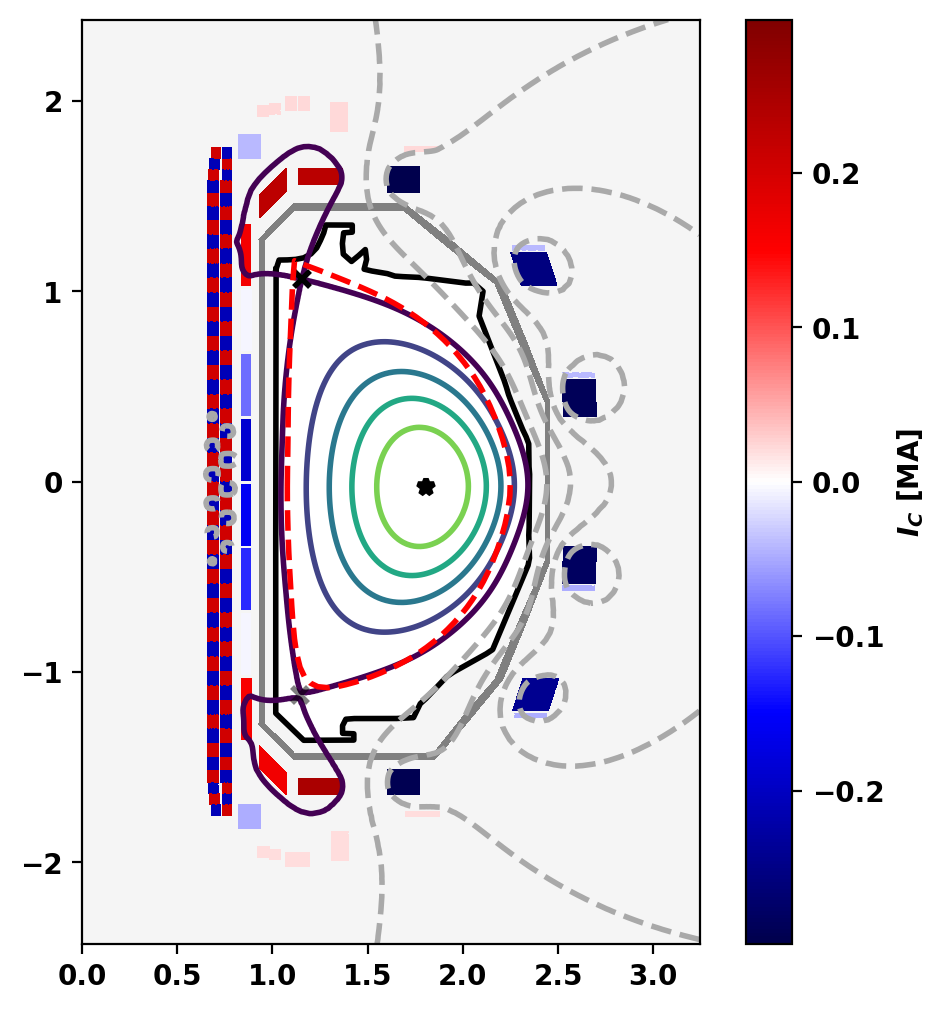

In [20]:
psi_eq = mygs.get_psi()
mygs.print_info()

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,normalized=True,plasma_nlevels=6,vacuum_nlevels=5)
# mygs.plot_psi(fig,ax,psi_eq,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')
_ = ax.plot(eqdsk['rzout'][:,0], eqdsk['rzout'][:,1],'r--')
# plot_sensors({**fluxLoops_vv, **fluxLoops_onf}, label="Flux Loop", color='cyan')

plt.show()

In [21]:
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    if key not in target_currents:
        continue
    current_adj = current
    # if key.startswith('F'):
    #     current_adj = current/machine_dict['FCOIL'][key][4]
    measured_currt = target_currents[key]
    pct_diff = 100.0 * (current_adj-measured_currt)/measured_currt
    print('  {0:10} {1:11.3F} {2:11.3F} {3:10.2F}%'.format(key+":", current_adj/1.E3, measured_currt/1.E3, pct_diff))

Coil Currents [kA]:
  F1A:            -3.247      -3.237       0.30%
  F2A:            -1.459      -1.461      -0.14%
  F3A:            -0.105      -0.112      -6.05%
  F4A:             2.789       2.779       0.35%
  F5A:             3.911       3.908       0.07%
  F6A:            -5.228      -5.091       2.71%
  F7A:            -4.670      -4.751      -1.70%
  F8A:             3.966       3.982      -0.39%
  F9A:            -5.437      -5.411       0.48%
  F1B:            -2.732      -2.714       0.65%
  F2B:            -2.167      -2.158       0.41%
  F3B:            -0.098      -0.101      -2.94%
  F4B:             2.732       2.724       0.30%
  F5B:             2.843       2.842       0.05%
  F6B:            -5.129      -4.980       2.98%
  F7B:            -4.404      -4.504      -2.23%
  F8B:             4.278       4.294      -0.37%
  F9B:            -5.325      -5.345      -0.39%


## Plot Measured vs. Computed SE Values

### Plot SE Currents

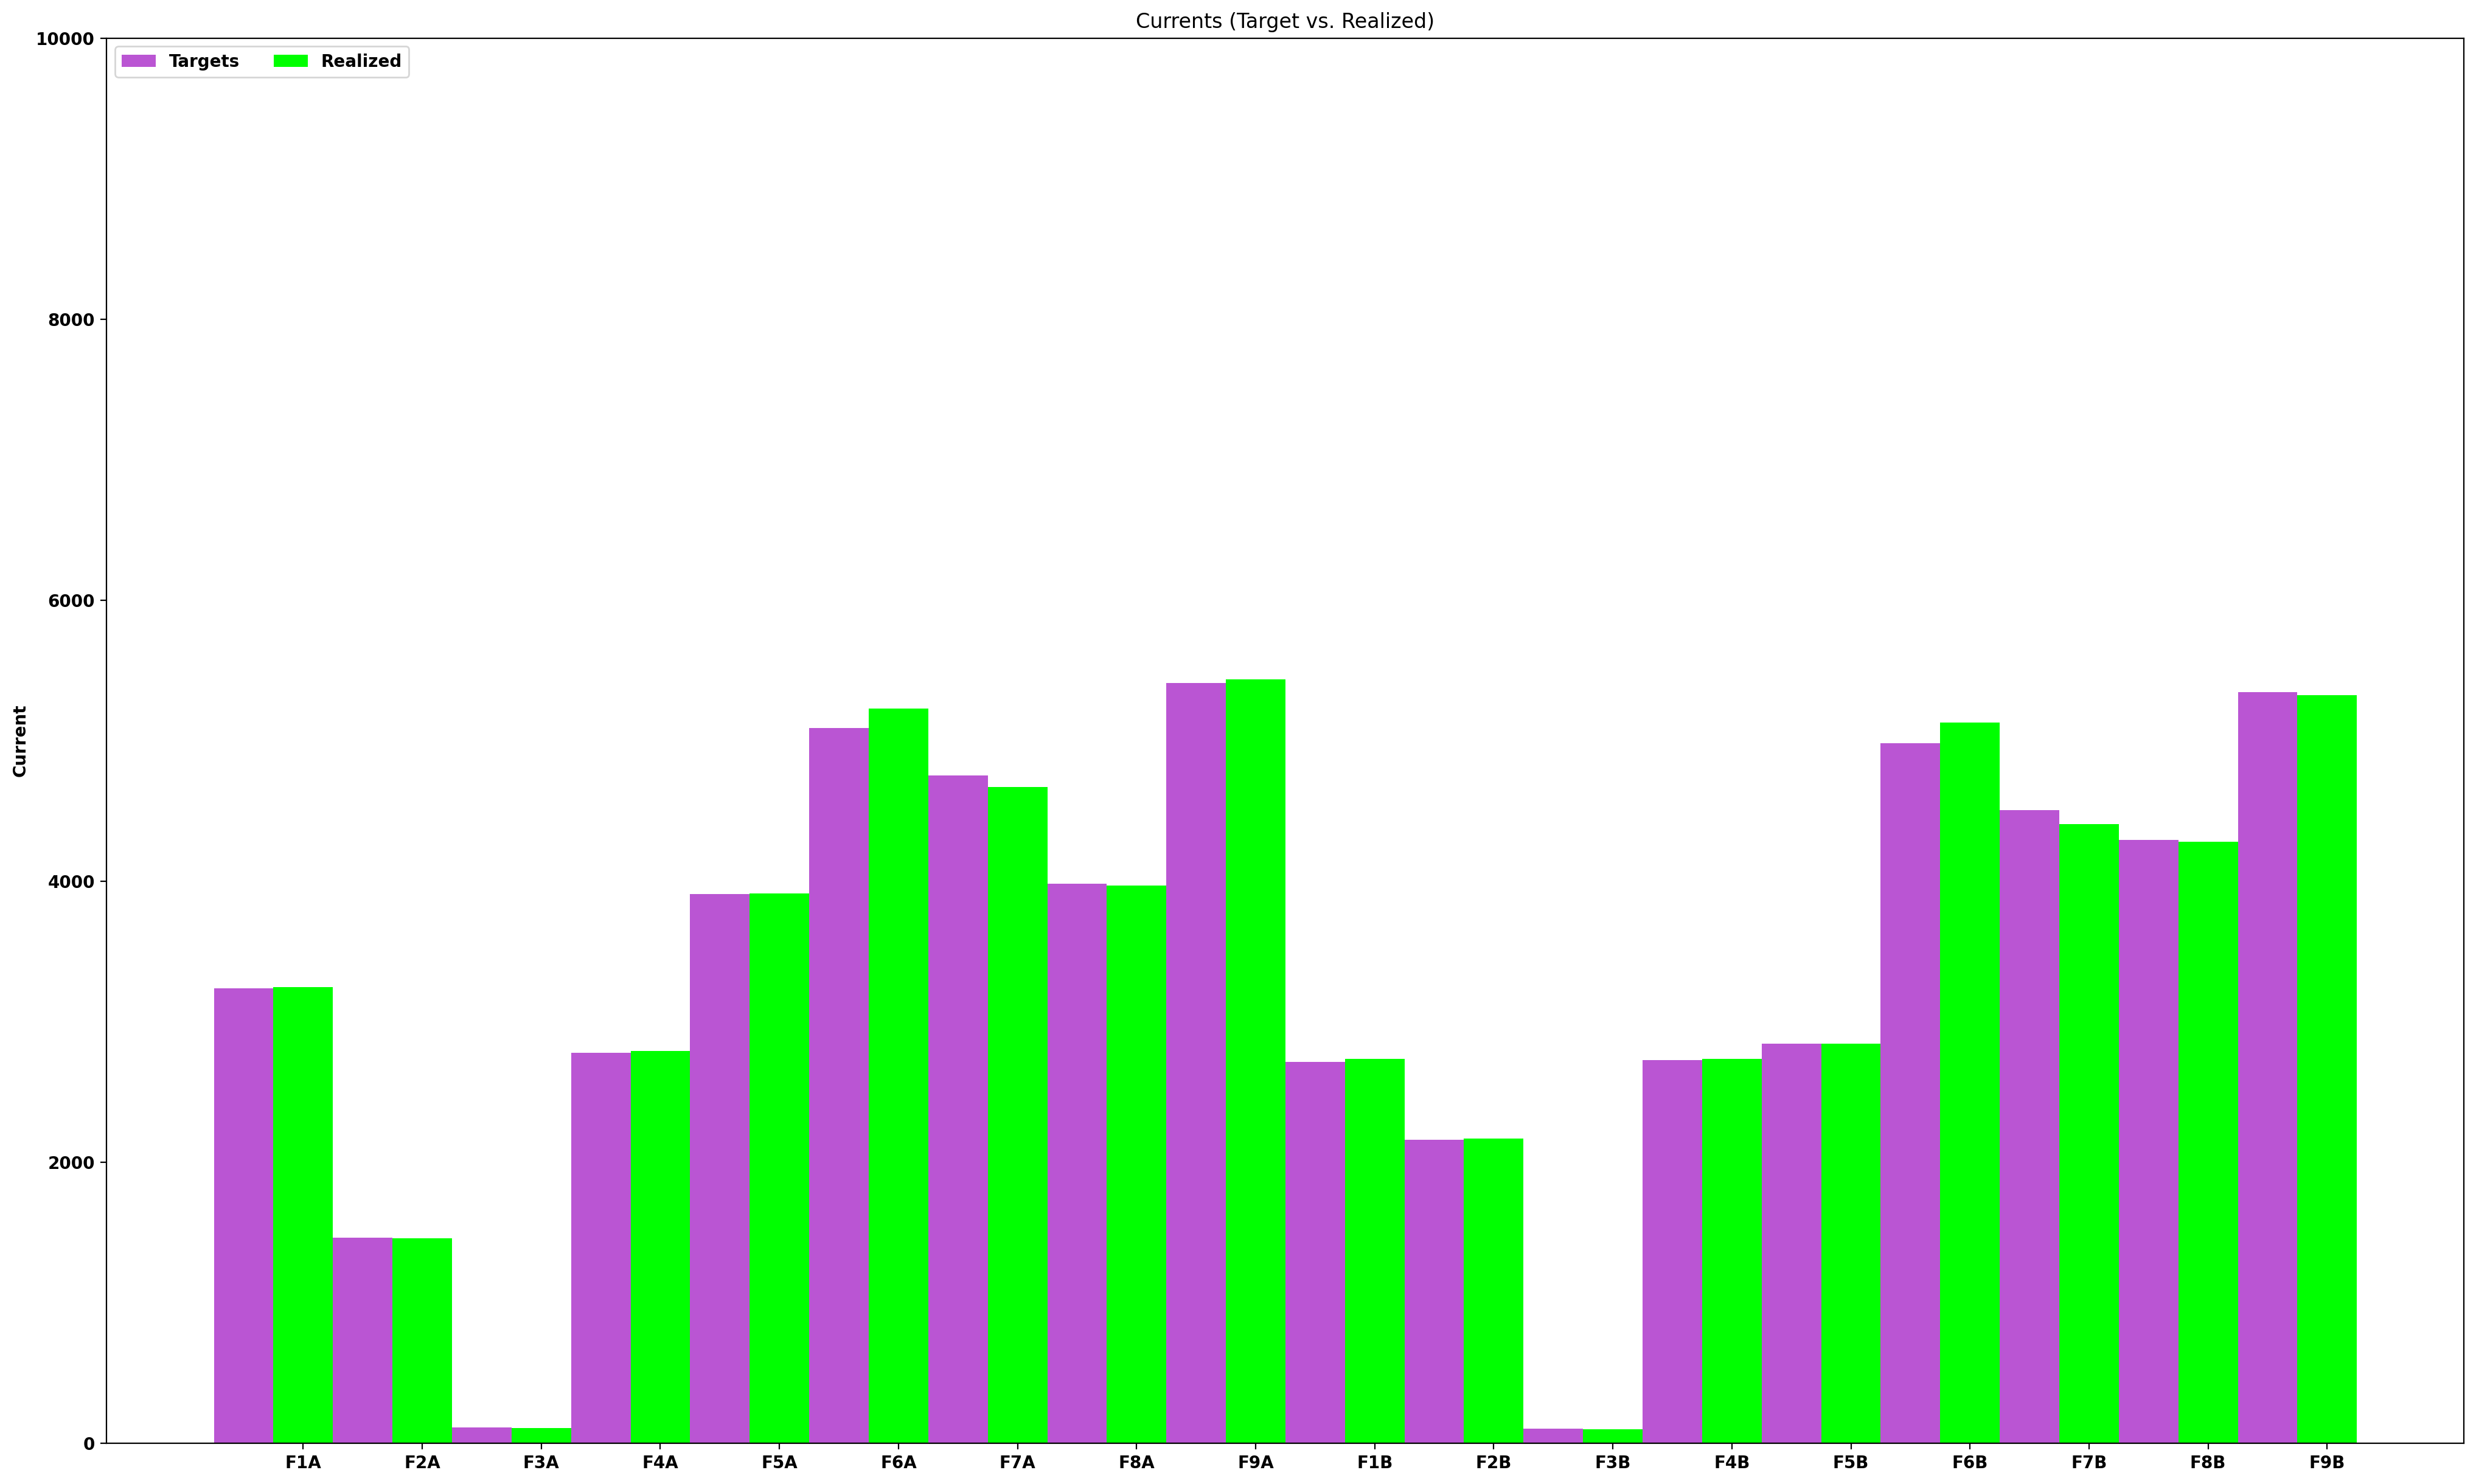

In [22]:
plot_colors = {'Targets': 'mediumorchid', 'Realized': 'lime', 'Error': 'red'}

def plot_currents():
    coil_currents, _ = mygs.get_coil_currents()
    coil_names = [key for key in coil_currents if key in target_currents]
    coil_info = {'Targets': [abs(target_currents[key]) for key in coil_names if key in target_currents],
                 'Realized': [abs(coil_currents[key]) for key in coil_names if key in target_currents]}
    coil_err = np.array([np.abs(target_errs[key]) for key in coil_names if key in target_currents])

    x = np.arange(len(coil_names))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(25, 15))
    
    for attribute, measurement in coil_info.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=plot_colors[attribute])
        multiplier += 1
    
    ax.set_ylabel('Current')
    ax.set_title('Currents (Target vs. Realized)')
    ax.set_xticks(x + width, coil_names)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1.0E4)

    x_c = np.arange(len(coil_names))

    plt.show()

plot_currents()

### Plot SE Sensors

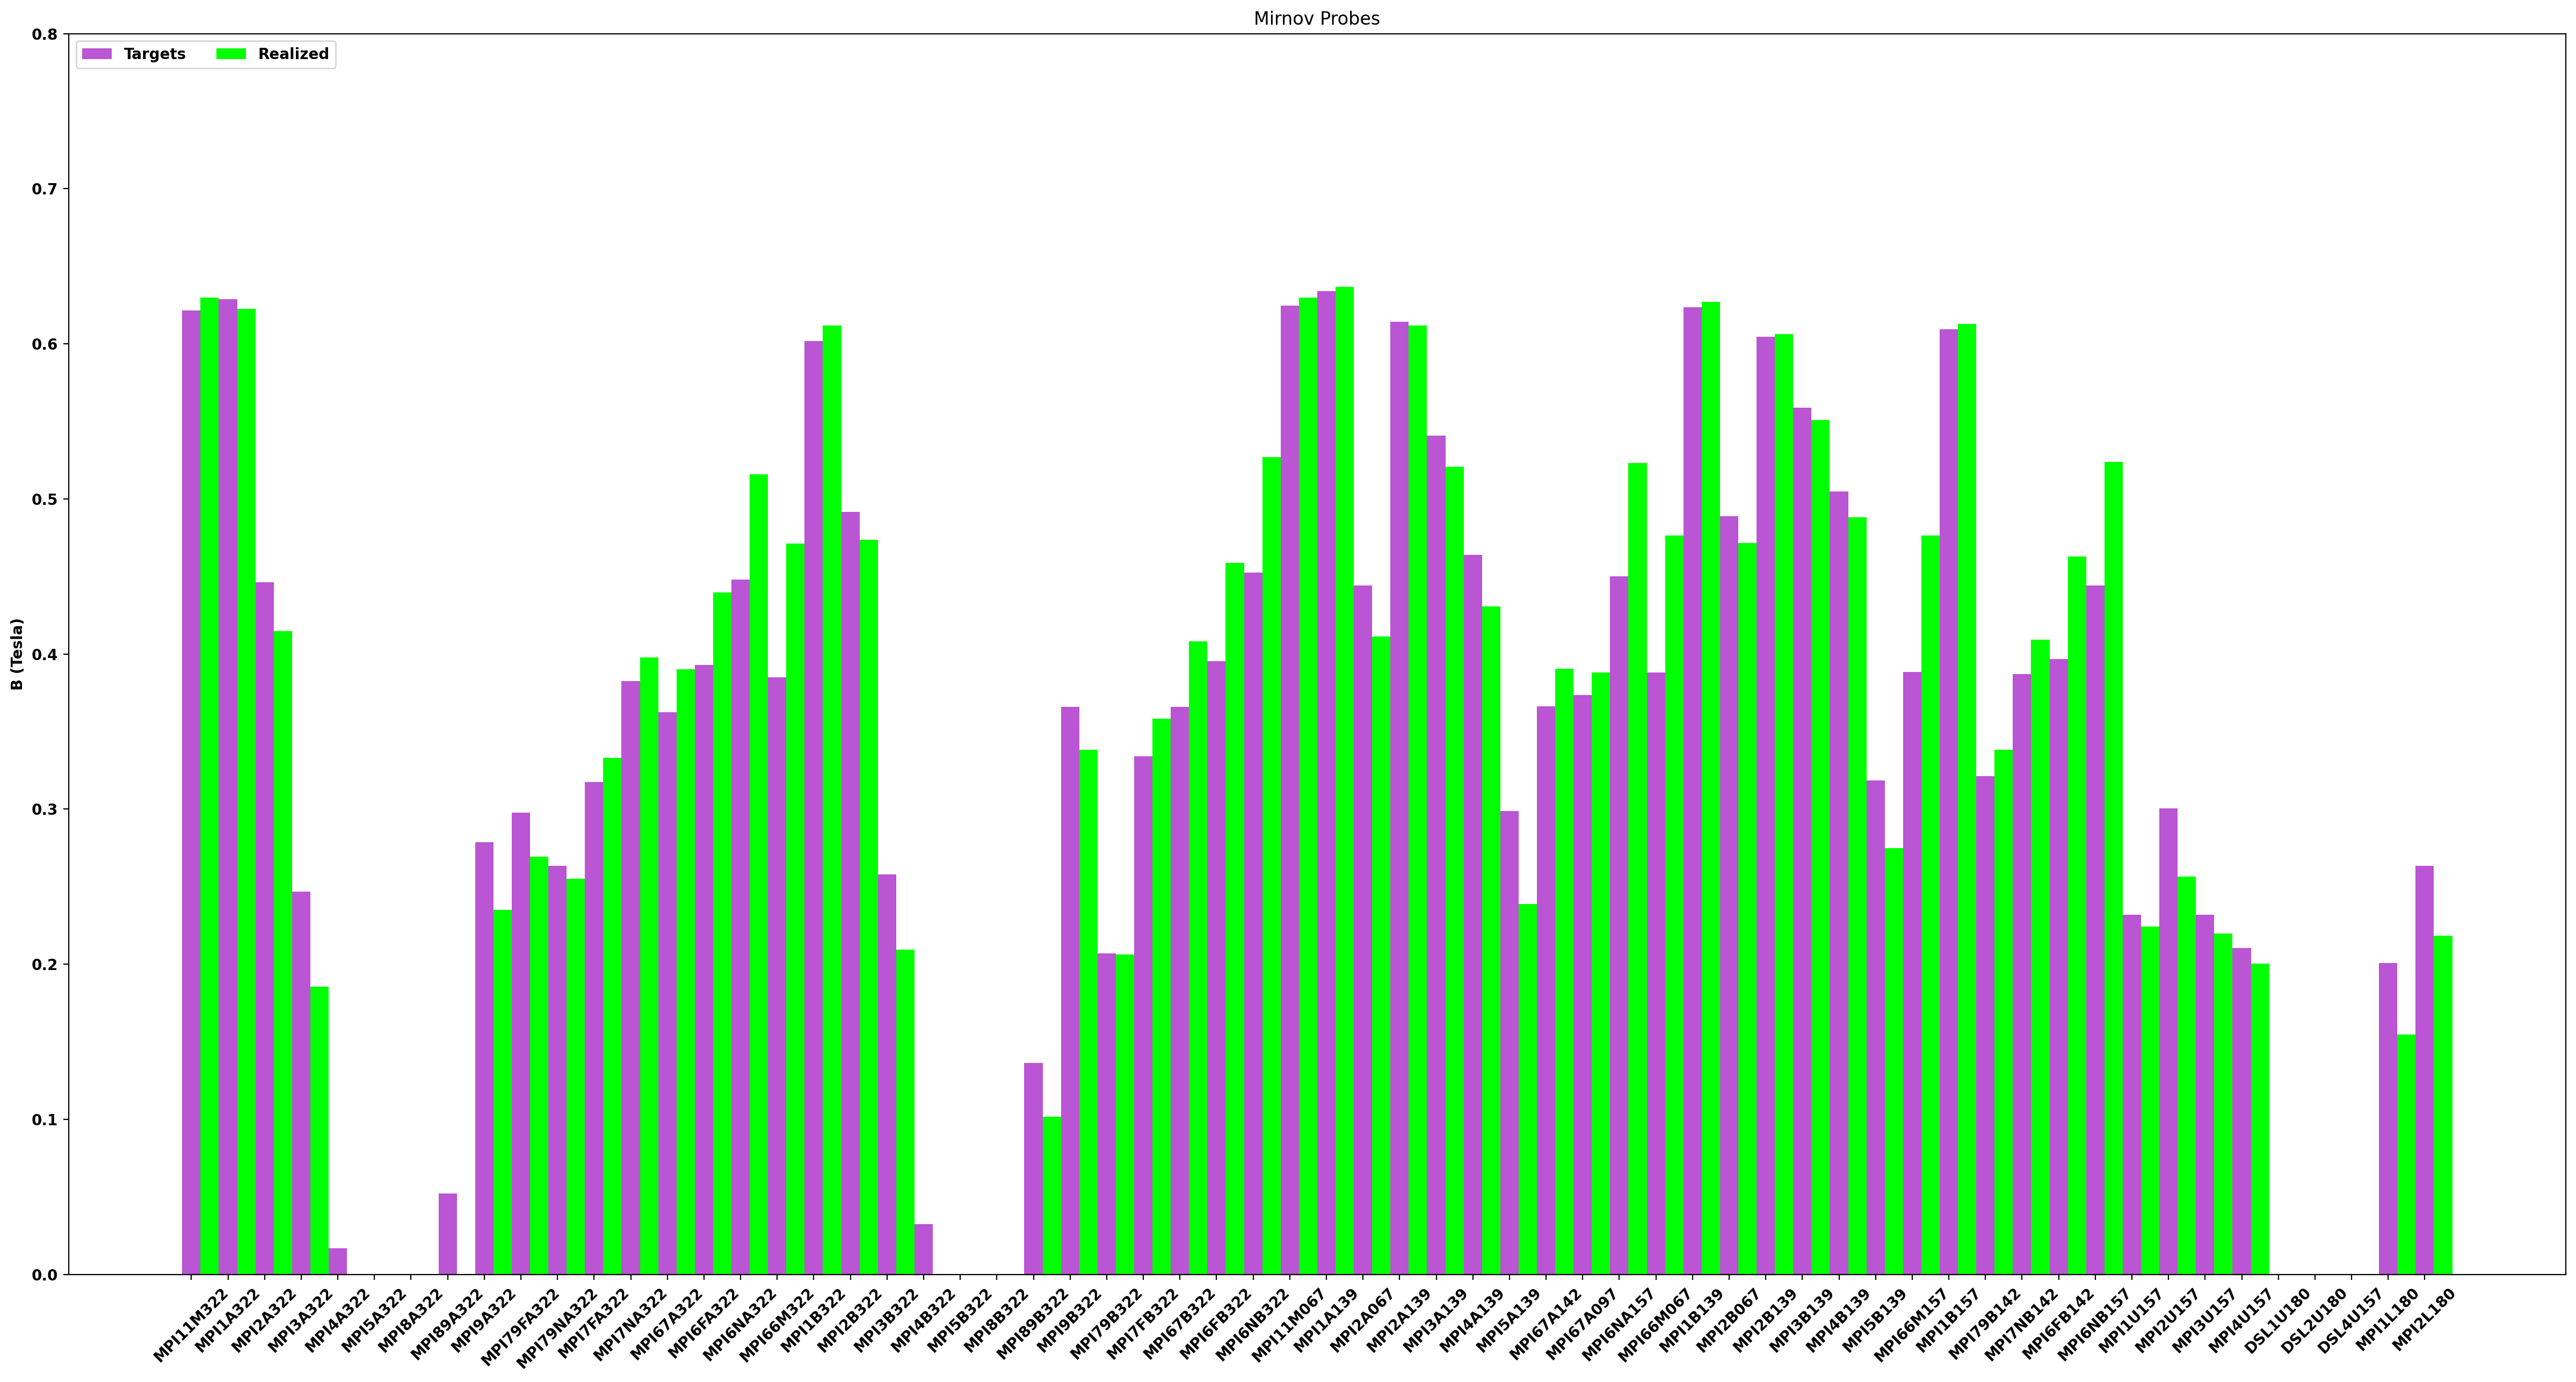

In [23]:
def plot_mirnov():
    mirnov_vals = []
    B_eval = mygs.get_field_eval('B')
    for key in mirnov_names:
        coords = magSensors322[key]
        position, orientation = convert_Mirnov_coordinates(coords, machine_dict['AMP2'][key])
        B_field = B_eval.eval(position)
        mirnov_vals.append(np.dot(B_field, orientation))
    
    mirnov_targets = [probes_dict[key][0] if key in probes_dict else 0.0 for key in mirnov_names]
    mirnov_info = {'Targets': mirnov_targets,
                 'Realized': mirnov_vals}
    
    x_m = np.arange(len(mirnov_names))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(1, figsize=(30, 15))
    
    for attribute, measurement in mirnov_info.items():
        offset = width * multiplier
        rects_m = ax.bar(x_m + offset, measurement, width, label=attribute, color=plot_colors[attribute])
        multiplier += 1
    
    ax.set_ylabel('B (Tesla)')
    ax.set_title('Mirnov Probes')
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 0.8)
    ax.set_xticks(x_m, labels=mirnov_names, rotation=45)

    x_m = np.arange(len(mirnov_names))  # the label locations
    mirnov_mean = np.mean((np.abs(mirnov_targets)))

    plt.show()

plot_mirnov()

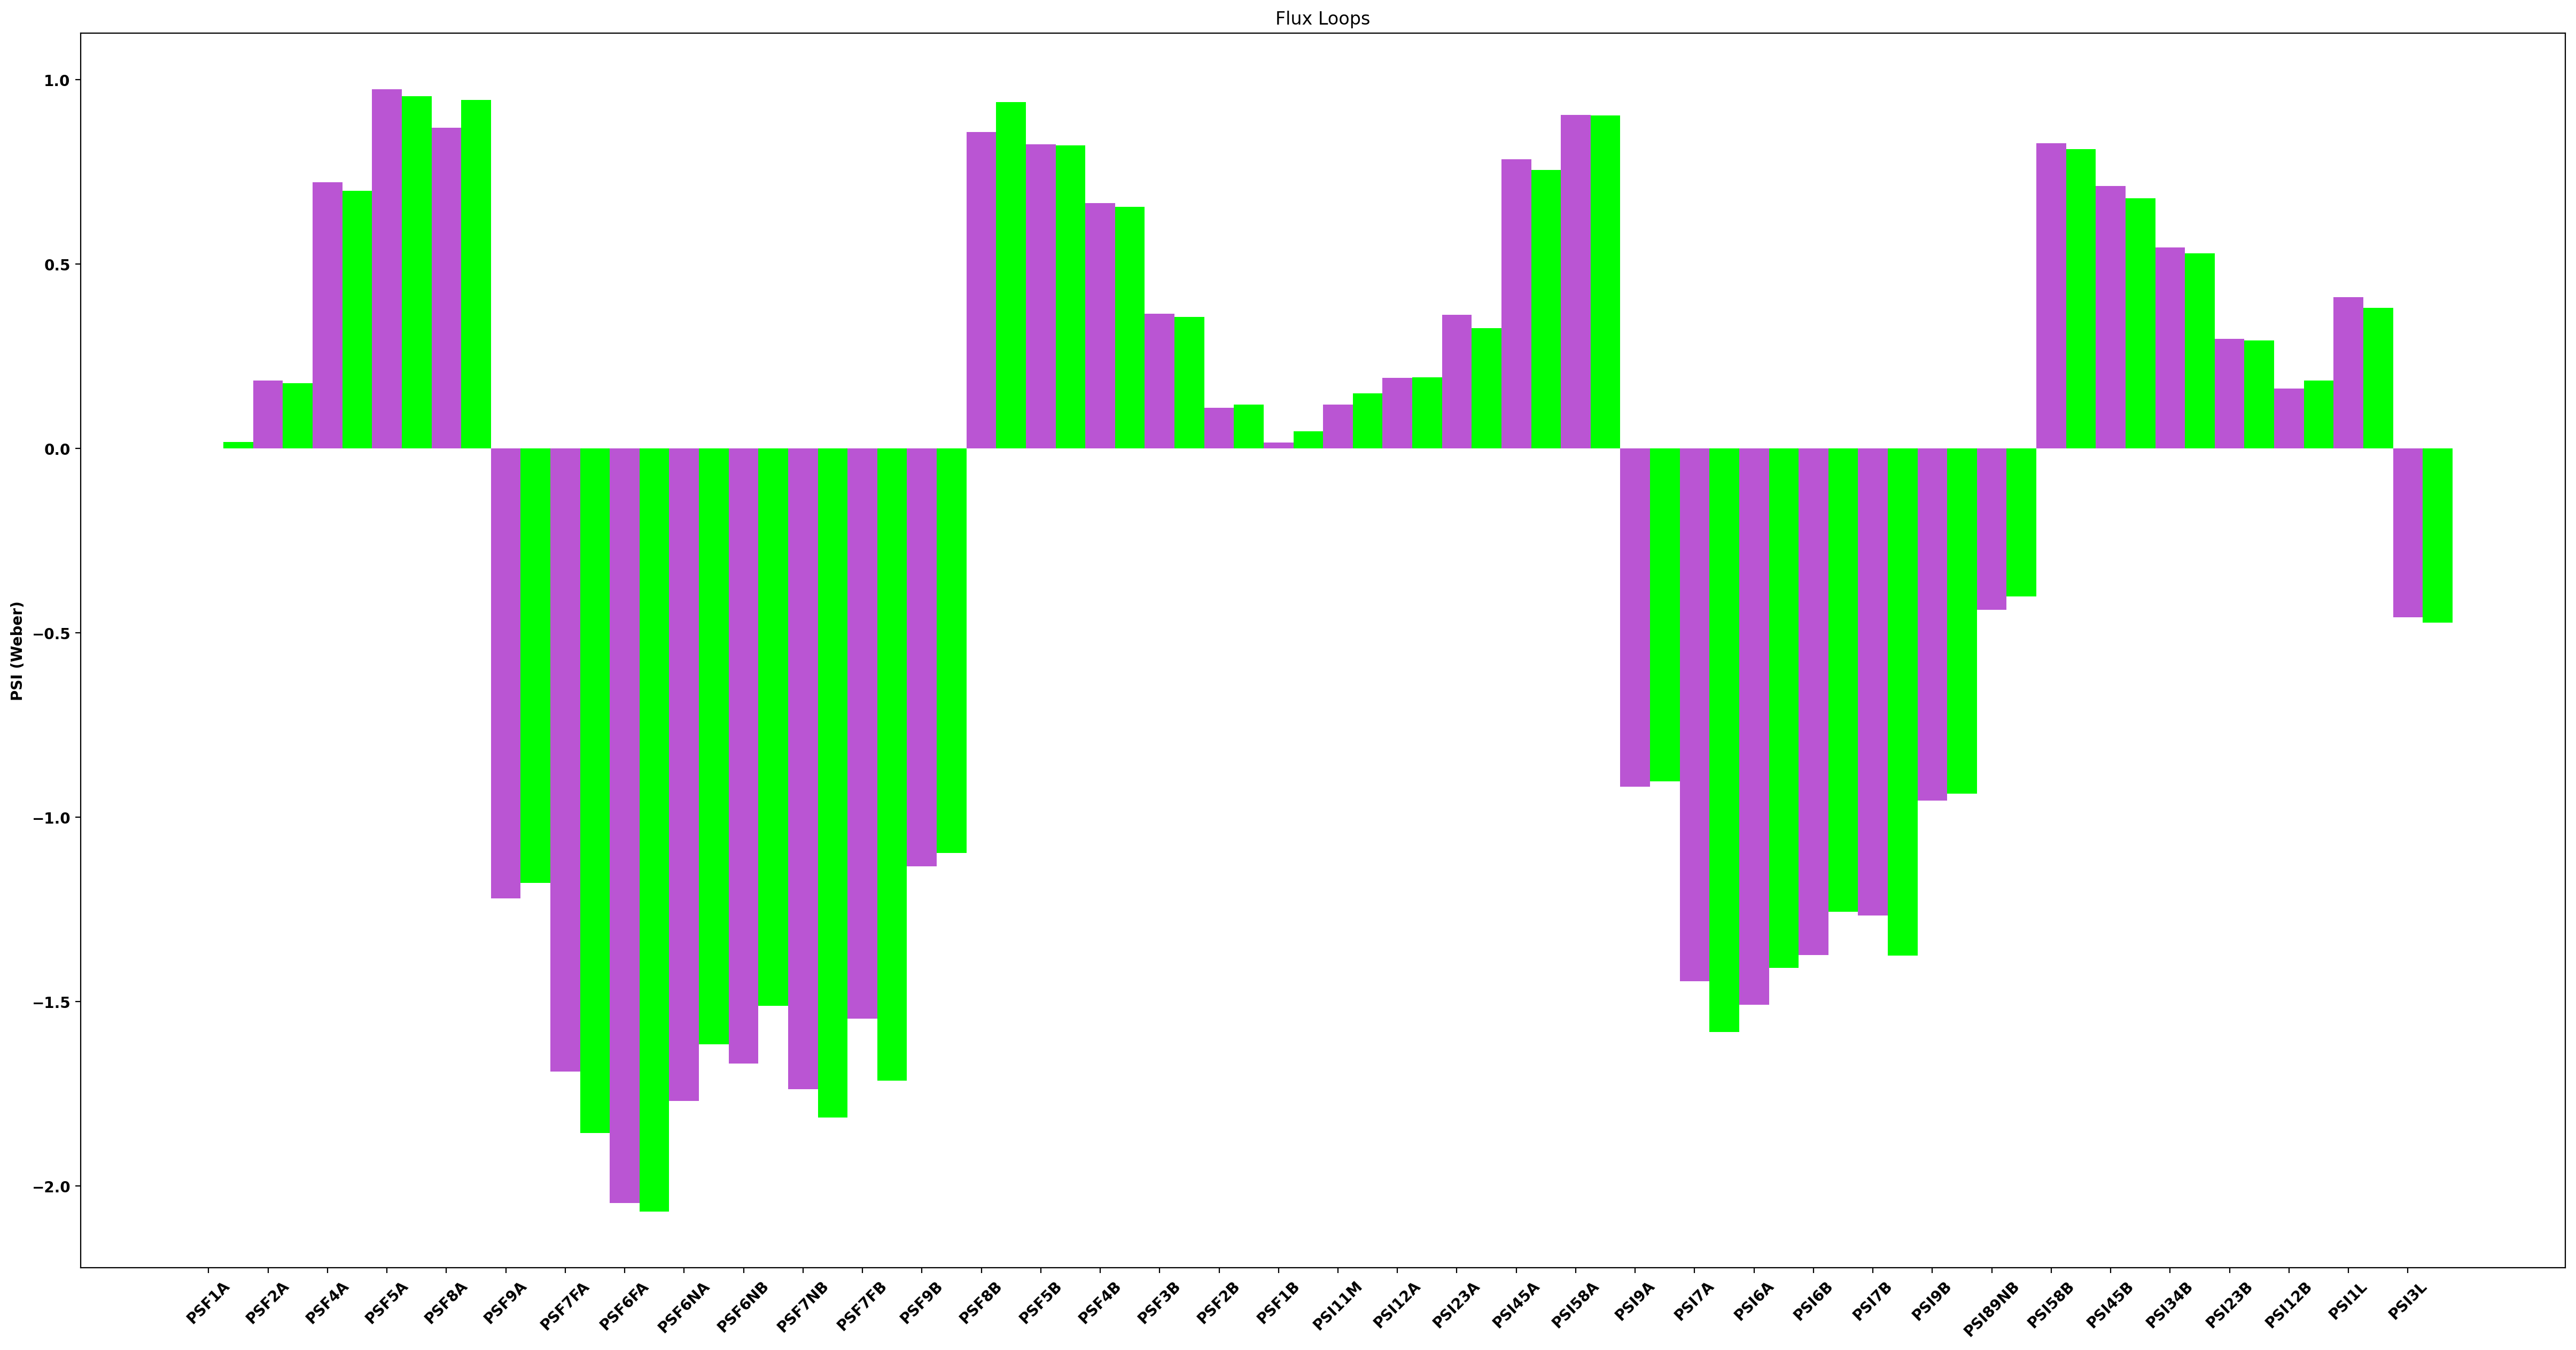

In [24]:
from matplotlib.patches import Patch

def plot_flux():
    flux_vals = []
    flux_dict = {**fluxLoops_onf, **fluxLoops_vv}
    psi_eval = mygs.get_field_eval('PSI')
    for key in flux_names:
        position = flux_dict[key]
        psi_value = psi_eval.eval(position) * 2 * np.pi
        flux_vals.append(psi_value[0])

    flux_targets = [2 * np.pi * loops_dict[key][0] for key in flux_names]
    flux_errs = [2 * np.pi * loops_dict[key][1] for key in flux_names]

    figs, ax = plt.subplots(1, figsize=(30, 15))

    x_f = np.arange(len(flux_names))  # the label locations
    ax.bar(x = x_f, height = flux_targets, width=0.5, label='Targets', color=plot_colors['Targets'])
    ax.bar(x = x_f + 0.5, height = flux_vals, width=0.5, label='Realized', color=plot_colors['Realized'])

    ax.set_ylabel('PSI (Weber)')
    ax.set_title('Flux Loops')
    # ax.set_ylim(0, 1.5)
    ax.set_xticks(x_f, labels=flux_names, rotation=45)

    # ax.errorbar(x_f, flux_targets, yerr=1.0/np.abs(np.array(flux_errs)), color=plot_colors['Error'], linestyle='none', elinewidth=6.0)

    plt.show()

plot_flux()

### Perform Reconstruction

In [25]:
# Remove all shape constraints
mygs.set_isoflux(None)
mygs.set_flux(None,None)
mygs.set_saddles(None)

# Set initial position targets from current values
mygs.set_targets(R0=mygs.o_point[0],V0=mygs.o_point[1])

# Set Recon Plasma Current
myrecon.set_Ip(Ip_target, err=0.1*Ip_target)

# Set reconstruction settings
myrecon.settings.fitPnorm = False
myrecon.settings.fitR0 = True
myrecon.settings.fitV0 = True
myrecon.settings.fitCoils = True
myrecon.settings.pm = False

# Perform reconstructions
mygs.settings.nl_tol=1.E-6
err_flag = myrecon.reconstruct()


*** Loading fit constraints ***

Starting Fit:
  # of free parameters   =   27
  # of constraints       =  125

Function evaluation    1
  Alam              =  1.408E-01
  P_scale           =  3.516E-06
  R0_target         =  1.804E+00
  V0_target         = -2.755E-02
  Coil currents [%]  = -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00  0.000E+00 -0.000E+00  0.000E+00
  Maximum Rel Error =  1.560E+02
  Maximum Abs Error =  3.037E-01
  Total Weighted Error   =  1.560E+03
  RMS Weighted Error     =  1.395E+02

Function evaluation    2
  Alam              =  1.408E-01
  P_scale           =  3.516E-06
  R0_target         =  1.804E+00
  V0_target         = -2.755E-02
  Coil currents [%]  = -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00

### Print equilibrium information and coil currents
As above we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" to display information on the final equilibrium.

In [26]:
mygs.print_info()

print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    if key not in target_currents:
        continue
    measured_currt = target_currents[key]
    pct_diff = 100.0 * (current-measured_currt)/measured_currt
    print('  {0:10} {1:11.3F} {2:11.3F} {3:10.2F}%'.format(key+":", current/1.E3, measured_currt/1.E3, pct_diff))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.7659E+06
  Current Centroid [m]    =    1.719 -0.024
  Magnetic Axis [m]       =    1.779 -0.024
  Elongation              =    1.676 (U:  1.706, L:  1.646)
  Triangularity           =    0.782 (U:  0.824, L:  0.740)
  Plasma Volume [m^3]     =   20.665
  q_0, q_95               =   -0.688 -3.780
  Peak Pressure [Pa]      =    2.6692E+05
  Stored Energy [J]       =    1.9306E+06
  <Beta_pol> [%]          =   101.0141
  Diamagnetic flux [Wb]   =   -1.4714E-02
  Toroidal flux [Wb]      =   -4.8370E+00
  l_i                     =    1.3071

Coil Currents [kA]:
  F1A:            -3.377      -3.237       4.32%
  F2A:            -1.429      -1.461      -2.18%
  F3A:            -0.105      -0.112      -6.26%
  F4A:             2.825       2.779       1.64%
  F5A:             3.943       3.908       0.90%
  F6A:            -5.077      -5.091      -0.27%
  F7A:            -4.372      -4.751      -7.9

## Plot final reconstructed equilibrium

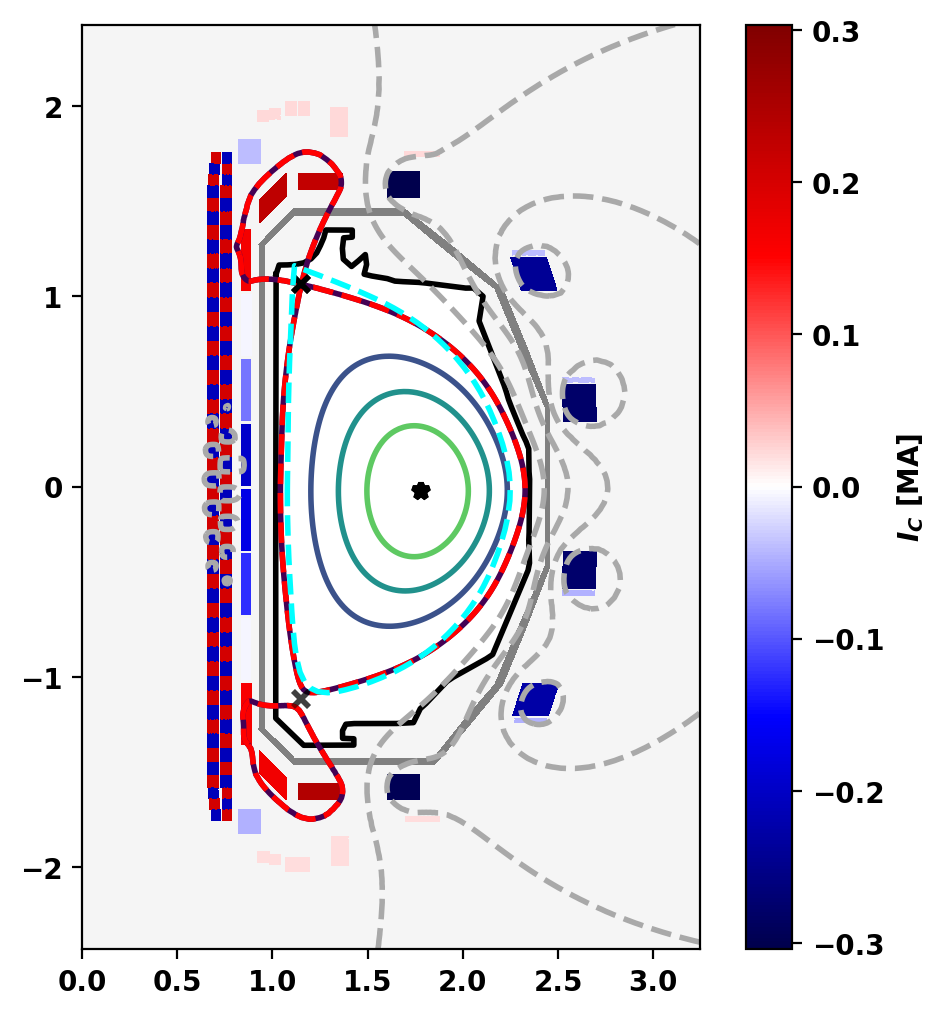

In [27]:
# Plot Psi
psi_recons = mygs.get_psi()
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_psi(fig,ax,psi_recons,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')

LCFS_eqdsk = eqdsk['rzout']
ax.plot(LCFS_eqdsk[:,0], LCFS_eqdsk[:,1], color='cyan', linestyle='--')

plt.show()

## Plot Current Density

In [ ]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(1,1)
cmap = ListedColormap([[0.0, 0.0, 0.0, 0.5]])

mygs.plot_machine(fig,ax,coil_clabel=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5, plasma_colormap=cmap)
mygs.plot_current_density(fig, ax)

# Show the plot
plt.show()

Starting CG solver
     0  0.000000E+00  0.000000E+00  8.133018E-01
     1 -3.299999E+03  1.273820E+04  1.079668E-01  8.475828E-06
     2 -3.470191E+03  1.489616E+04  5.197558E-02  3.489192E-06
     3 -3.481487E+03  1.508763E+04  1.410722E-02  9.350193E-07
     4 -3.482108E+03  1.510364E+04  5.851524E-03  3.874248E-07
     5 -3.482212E+03  1.509238E+04  2.459411E-03  1.629571E-07
     6 -3.482231E+03  1.509155E+04  8.853862E-04  5.866767E-08
     7 -3.482234E+03  1.509191E+04  3.218973E-04  2.132913E-08
     8 -3.482234E+03  1.509163E+04  1.205135E-04  7.985454E-09
     9 -3.482234E+03  1.509175E+04  5.347392E-05  3.543255E-09
    10 -3.482234E+03  1.509168E+04  2.224816E-05  1.474201E-09
    20 -3.482234E+03  1.509168E+04  1.416991E-09  9.389217E-14


## Plot Currents

In [ ]:
plot_currents()

In [ ]:
plot_mirnov()

In [ ]:
plot_flux()

## Get Strike Points

In [ ]:
strike_pts = mygs.get_strike_points()

In [ ]:
# Plot Psi
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_psi(fig,ax,psi_eq,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')

strike_pts_r = [sp[0] for sp in strike_pts]
strike_pts_z = [sp[1] for sp in strike_pts]
ax.scatter(strike_pts_r, strike_pts_z, color='limegreen', zorder=10)

plt.show()